In [486]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA
import json
from sklearn.cluster import DBSCAN

In [535]:
iv_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'succuessfulForwardPasses', 
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'progressiveRun'
         ]
lb_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'successfulForwardPasses', 
         'crosses', 
         'successfulCrosses',
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'interceptions',
         'progressiveRun',
         'xgAssist'
         ]
midfield_list= ['pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'xgAssist',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgShot',
                'touchInBox',
                'offensiveDuels'
]

wing_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'successfulPasses',
          'keyPasses',
          'pressingDuels', 
          'crosses',
          'dribbles',
          'progressiveRun',
          'offensiveDuels',
          'offensiveDuelsWon'

]

striker_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'keyPasses',
          'progressivePasses',
          'losses', 
          'ownHalfLosses',
          'recoveries',
          'opponentHalfRecoveries'
    
]
offmid_list=[   'pressingDuels', 
                'looseBallDuels',
                'looseBallDuelsWon',
                'recoveries',
                'opponentHalfRecoveries',
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'keyPasses',
                'xgAssist',
                'xgShot',
                'touchInBox',
                'offensiveDuels',
                'shotsOnTarget'
]

defmid_list=[   'pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgAssist'
]


In [514]:
loss_list= [
    'total.losses',
    'total.ownHalfLosses',
    'total.dangerousOwnHalfLosses'
]

In [174]:
pd.set_option('display.max_columns', 5000)

In [175]:
def get_player(playerid, matchId):

    path='data/events/'+str(matchId)+'.json'
    with open(path, 'r', encoding='utf-8') as f:
        rd = f.read()
    rd=rd[28:-2]
    print(rd)
    obj = json.loads(rd)
    dfw = pd.json_normalize(obj)
    dfw=dfw[dfw['player.id']==playerid]
    return dfw['player.name'].iloc[0]

In [447]:
def remove_outliers(data, l, u,threshold=1.5):
    num_dimensions = data.shape[1]
    mask = np.ones(data.shape[0], dtype=bool)

    for dim in range(num_dimensions):
        q1 = np.percentile(data[:, dim], l)
        q3 = np.percentile(data[:, dim], u)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr

        # Update the mask for this dimension
        mask = np.logical_and(mask, (data[:, dim] >= lower_bound) & (data[:, dim] <= upper_bound))

    cleaned_data = data[mask]
    return cleaned_data

In [193]:
def centroiddf(resdf, meanarray):
    empty_df = pd.DataFrame(columns=resdf.columns)
    for i in range(meanarray.shape[0]):
        empty_df.loc[i]=meanarray[i]

    return empty_df

In [481]:
def preprocessarray(attr_list, file, rem, l, u):
    cluster_attr=[]
    for word in attr_list:
        cluster_attr = cluster_attr+['total.'+word]
    df=pd.read_csv(file)
    dfcalc = df[df.columns[df.columns.isin(cluster_attr)]]
    for w in loss_list:
        if(w in cluster_attr):
            df[w]*=-1
            dfcalc[w]*=-1
    arr=dfcalc.to_numpy()
    print('total points')
    print(arr.shape)
    
    m=abs(arr.min())+0.5
    if(rem):
        arr=remove_outliers(arr, l, u)
    print('after cleanup:', arr.shape)
    return arr+m, arr, df, dfcalc

In [572]:
filename='norm_stats/normalized_midfieldstats.csv'
figurename='midfield3.jpg'
poslist=midfield_list
remove=True
savefilename='midfield3clustering.csv'
elbowplot=True
n=3

processarray, ogarray, df, dfcalc=preprocessarray(poslist, filename, remove, 15,85)

total points
(3689, 24)
after cleanup: (3106, 24)


C:\Users\Rui\AppData\Local\Temp\ipykernel_20312\3283348093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcalc[w]*=-1


c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


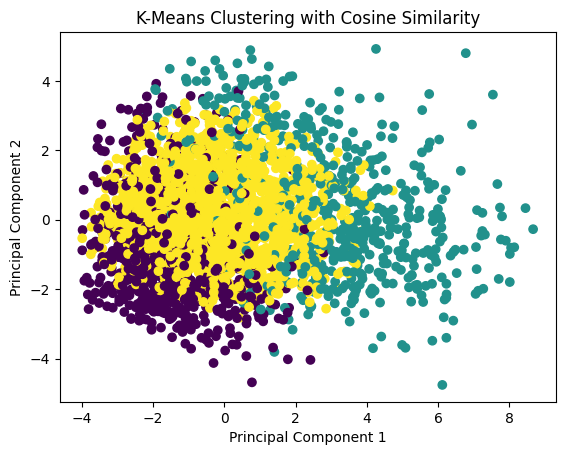

In [574]:
ass=clustering(n, figurename, False, processarray)

In [575]:
cluster_lists = [[] for _ in range(n)]
# Populate lists with indices
for i, label in enumerate(ass):
    cluster_lists[label].append(i)

meanarr=ogarray.copy()

columnarray=np.empty((0,ogarray.shape[1]))
stdarray=np.empty((0,ogarray.shape[1]))
for i in range(n):

    selected_rows = meanarr[cluster_lists[i], :]
    print('number of points in cluster',i)
    print(len(cluster_lists[i]))

    # Calculate the mean of every column separately for the selected rows
    column_means = np.mean(selected_rows,axis=0)
    column_std = np.std(selected_rows,axis=0)
    mean_reshaped= column_means.reshape(1,-1)
    std_reshaped = column_std.reshape(1,-1)
    columnarray=np.concatenate((columnarray,mean_reshaped), axis=0)
    stdarray=np.concatenate((stdarray,std_reshaped),axis=0)
    print("Mean of every column separately:",i)
    print (column_means)
    print(column_std)

number of points in cluster 0
740
Mean of every column separately: 0
[-0.07327651 -0.13714575  0.64018395 -0.55762744 -0.57282764 -0.53920818
 -0.63041364 -0.60649705 -0.1192517  -0.09125665  0.11234337 -0.50573405
 -0.47438304 -0.38252563  0.5443445  -0.60612576 -0.36999413 -0.30387469
  0.03370258  0.06864788  0.04193926 -0.47669042  0.37331682  0.25893105]
[1.12465188 0.99394524 1.11141352 0.58972232 0.57254777 0.4825833
 0.54983875 0.51724402 0.74085571 0.75893242 0.92186612 0.60747756
 0.55998644 0.89424662 1.1727139  0.72528783 0.77719208 1.06404881
 1.05760884 0.69620224 0.7683266  0.60155215 0.96712185 1.04137653]
number of points in cluster 1
557
Mean of every column separately: 1
[ 0.10477042  0.19159825 -0.30060102  0.98376763  0.97322169  0.87262648
  0.98732634  0.95399898  0.15583327  0.04926044 -0.11503313  0.77684887
  0.7608218   0.46150383 -0.44439717  0.77813784  0.59686777 -0.20822712
 -0.26178312 -0.25439457 -0.15882344  0.88248864 -0.31502041 -0.03182031]
[1.11649

In [576]:
meandf=centroiddf(dfcalc,columnarray)
stddf=centroiddf(dfcalc, stdarray)
meandf.to_csv('mean_'+savefilename)
stddf.to_csv('std_'+savefilename)

In [577]:
meandf

,total.defensiveDuels,total.defensiveDuelsWon,total.offensiveDuels,total.passes,total.successfulPasses,total.passesToFinalThird,total.forwardPasses,total.successfulForwardPasses,total.throughPasses,total.successfulThroughPasses,total.keyPasses,total.longPasses,total.successfulLongPasses,total.interceptions,total.pressingDuels,total.recoveries,total.opponentHalfRecoveries,total.losses,total.ownHalfLosses,total.xgShot,total.xgAssist,total.receivedPass,total.touchInBox,total.progressiveRun
0,-0.073277,-0.137146,0.640184,-0.557627,-0.572828,-0.539208,-0.630414,-0.606497,-0.119252,-0.091257,0.112343,-0.505734,-0.474383,-0.382526,0.544345,-0.606126,-0.369994,-0.303875,0.033703,0.068648,0.041939,-0.476690,0.373317,0.258931
1,0.104770,0.191598,-0.300601,0.983768,0.973222,0.872626,0.987326,0.953999,0.155833,0.049260,-0.115033,0.776849,0.760822,0.461504,-0.444397,0.778138,0.596868,-0.208227,-0.261783,-0.254395,-0.158823,0.882489,-0.315020,-0.031820
2,0.039733,-0.032251,-0.300430,-0.279910,-0.251341,-0.237284,-0.226545,-0.219774,-0.282856,-0.251639,-0.286985,-0.171407,-0.185586,0.066411,-0.135151,0.007631,-0.121420,0.310007,-0.034293,-0.294547,-0.292686,-0.293943,-0.343869,-0.291850


In [571]:
stddf

,total.defensiveDuels,total.defensiveDuelsWon,total.offensiveDuels,total.passes,total.successfulPasses,total.passesToFinalThird,total.forwardPasses,total.successfulForwardPasses,total.throughPasses,total.successfulThroughPasses,total.keyPasses,total.longPasses,total.successfulLongPasses,total.interceptions,total.pressingDuels,total.recoveries,total.opponentHalfRecoveries,total.losses,total.ownHalfLosses,total.xgShot,total.xgAssist,total.receivedPass,total.touchInBox,total.progressiveRun
0,0.779149,0.759284,0.698934,0.652650,0.657747,0.583543,0.633046,0.631400,0.549453,0.503744,0.490778,0.677775,0.671466,0.769123,0.749711,0.718627,0.783792,0.760319,0.808107,0.406471,0.463972,0.650615,0.534080,0.650502
1,1.084931,1.161000,0.742009,0.692317,0.705597,0.643013,0.697997,0.697227,0.589044,0.612707,0.514909,0.832251,0.806418,1.089647,0.921938,0.930253,1.081557,1.026515,1.144731,0.436481,0.434313,0.682520,0.477084,0.612825
2,0.975541,0.958794,0.777869,0.801306,0.857932,0.873156,0.808553,0.891204,0.941119,0.895993,0.811546,1.097115,1.140358,1.037831,0.608295,1.091372,1.177423,1.046048,1.003808,0.433751,0.644489,0.865913,0.598269,0.992883
3,0.930236,0.828169,1.093231,0.600714,0.582123,0.487179,0.560031,0.527663,0.768312,0.797726,0.953782,0.601710,0.573126,0.703736,1.176680,0.579838,0.720770,1.068662,0.912320,0.703069,0.789059,0.604815,0.969578,1.052904


c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


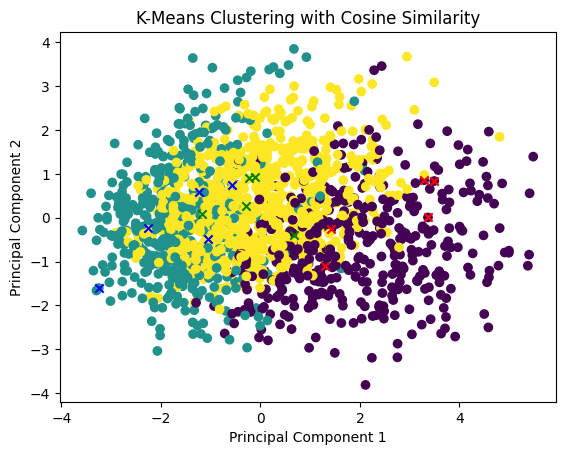

In [544]:
#0=red, 1=blue, 2=green, 3=black, 4= cyan, 5=white

cosine_distances = pairwise_distances(processarray, metric='cosine')
kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
kmeans.fit(cosine_distances)
# Get the cluster assignments
cluster_assignments = kmeans.labels_

# Reduce dimensionality using PCA for visualization (2D)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(processarray)
cluster_lists = [[] for _ in range(n)]
for i, label in enumerate(cluster_assignments):
    cluster_lists[label].append(i)
# Plot the results
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis')

for a in range(5):
    pointlist= cluster_lists[0]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='red')

for a in range(5):
    pointlist= cluster_lists[1]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='blue')

for a in range(5):
    pointlist= cluster_lists[2]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='green')
'''
for a in range(5):
    pointlist= cluster_lists[3]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='cyan')
for a in range(5):
    pointlist= cluster_lists[2]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='green')
'''
name='withcrosses_'+figurename
plt.title('K-Means Clustering with Cosine Similarity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(name)
plt.show()

In [566]:
def clustering(n, figurename, elbow, arr):
    if(elbow):
        k_values = range(1, 10)

        # Calculate and store the inertia for each k
        inertia_values = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=42)
            cosine_distances = pairwise_distances(arr, metric='cosine')
            kmeans.fit(cosine_distances)
            inertia_values.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, inertia_values, marker='o')
        plt.title('Loss per cluster')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.savefig('elbow'+figurename)
        plt.show()
        return []
    else:
        cosine_distances = pairwise_distances(arr, metric='cosine')
        kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
        kmeans.fit(cosine_distances)
        # Get the cluster assignments
        cluster_assignments = kmeans.labels_

        # Reduce dimensionality using PCA for visualization (2D)
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(arr)
        # Plot the results
        plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis')
        #plt.scatter(data_2d[0, 0], data_2d[0, 1], marker='x', color='red', label='purple')
        #plt.scatter(data_2d[26, 0], data_2d[26, 1], marker='x', color='red', label='green')
        #plt.scatter(data_2d[11, 0], data_2d[11, 1], marker='x', color='red', label='yellow')
        #plt.scatter(data_2d[min_ind, 0], data_2d[min_ind, 1], marker='x', color='red', label='Min PC1')
        plt.title('K-Means Clustering with Cosine Similarity')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.savefig(figurename)
        plt.show()
        return kmeans.labels_

In [578]:
dataframe= pd.read_csv('mean_std/mean_midfieldclustering.csv')
dataframe

,Unnamed: 0,total.defensiveDuels,total.defensiveDuelsWon,total.offensiveDuels,total.passes,total.successfulPasses,total.passesToFinalThird,total.forwardPasses,total.successfulForwardPasses,total.throughPasses,total.successfulThroughPasses,total.keyPasses,total.longPasses,total.successfulLongPasses,total.interceptions,total.pressingDuels,total.recoveries,total.opponentHalfRecoveries,total.losses,total.ownHalfLosses,total.xgShot,total.xgAssist,total.receivedPass,total.touchInBox,total.progressiveRun
0,0,-0.051715,-0.140245,-0.300841,-0.273566,-0.241139,-0.231816,-0.237340,-0.222684,-0.278668,-0.250585,-0.287513,-0.182453,-0.193643,-0.038364,-0.130730,-0.100710,-0.169735,0.360791,0.057683,-0.287400,-0.287901,-0.273142,-0.333917,-0.284250
1,1,0.886030,0.781694,-0.307596,-0.224154,-0.237698,-0.171930,-0.035736,-0.108455,-0.258750,-0.211548,-0.294035,-0.001318,-0.059854,0.982898,-0.059748,0.940369,0.391749,-0.312883,-0.894004,-0.303051,-0.317504,-0.355508,-0.404471,-0.366421
2,2,-0.226373,-0.057376,-0.259656,1.402481,1.402193,1.262465,1.310896,1.314398,0.305224,0.115753,-0.014748,1.009750,1.017244,0.063235,-0.514144,0.491551,0.509390,-0.045043,0.094248,-0.242658,-0.081761,1.348611,-0.284637,0.122268
3,3,-0.319225,-0.314047,0.768803,-0.517376,-0.533509,-0.537945,-0.633865,-0.597566,-0.076087,-0.047734,0.175692,-0.510048,-0.458219,-0.564717,0.525594,-0.768022,-0.424681,-0.285202,0.218864,0.119024,0.097711,-0.418939,0.498262,0.374358


In [107]:
def cluster(attr_list, file, rem, l, u, n, figurename, elbow):
    cluster_attr=[]
    for word in attr_list:
        cluster_attr = cluster_attr+['total.'+word]
    df=pd.read_csv(file)
    dfcalc = df[df.columns[df.columns.isin(cluster_attr)]]
    #print(dfcalc.columns)
    for w in loss_list:
        if(w in cluster_attr):
            df[w]*=-1
            dfcalc[w]*=-1

    arr=dfcalc.to_numpy()
    m=abs(arr.min())+0.5
    arr=arr+m
    print(arr.shape)
    if(rem):
        arr=remove_outliers(arr, l, u)
    print(arr.shape)
    if(elbow):
        k_values = range(1, 10)

        # Calculate and store the inertia for each k
        inertia_values = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
            cosine_distances = pairwise_distances(arr, metric='cosine')
            kmeans.fit(cosine_distances)
            inertia_values.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, inertia_values, marker='o')
        plt.title('Loss per cluster')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.savefig('elbow'+figurename)
        plt.show()
        return dfcalc, []
    else:
        cosine_distances = pairwise_distances(arr, metric='cosine')
        kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
        kmeans.fit(cosine_distances)
        # Get the cluster assignments
        cluster_assignments = kmeans.labels_

        # Reduce dimensionality using PCA for visualization (2D)
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(arr)
        # Plot the results
        plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis')
        #plt.scatter(data_2d[0, 0], data_2d[0, 1], marker='x', color='red', label='purple')
        #plt.scatter(data_2d[26, 0], data_2d[26, 1], marker='x', color='red', label='green')
        #plt.scatter(data_2d[11, 0], data_2d[11, 1], marker='x', color='red', label='yellow')
        #plt.scatter(data_2d[min_ind, 0], data_2d[min_ind, 1], marker='x', color='red', label='Min PC1')
        plt.title('K-Means Clustering with Cosine Similarity')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.savefig(figurename)
        plt.show()



        cluster_lists = [[] for _ in range(n)]
        # Populate lists with indices
        for i, label in enumerate(cluster_assignments):
            cluster_lists[label].append(i)
        
        meanarr=arr.copy()-m

        columnarray=np.empty((0,arr.shape[1]))
        for i in range(n):

            selected_rows = meanarr[cluster_lists[i], :]

            # Calculate the mean of every column separately for the selected rows
            column_means = np.mean(selected_rows,axis=0)
            mean_reshaped= column_means.reshape(1,-1)
            print(column_means.shape)
            print(columnarray.shape)
            columnarray=np.concatenate((columnarray,mean_reshaped), axis=0)
            print("Mean of every column separately:",i)
            print (column_means)
        return dfcalc, columnarray

    
